# Modelling and Evaluation


### Objectives


* Answer business requirement 2:
   * The client is interested to tell whether a given leaf is infected or not.

## Inputs
* inputs/cherry_leaves_dataset/train
* inputs/cherry_leaves_dataset/test
* inputs/cherry_leaves_dataset/validate
* embedded image shapes

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file

----


# Change working directory

Import Packages

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

We need to change the working directory from its current folder to its parent folder

In [10]:
import os 
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [11]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [12]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-mildew-detection-in-cherry-leaves'

## Set Input Directories

In [13]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directories

In [14]:
version = 'v1'

file_path = f'outputs/{version}'
version_file_path = os.path.join(current_dir, file_path)

if os.path.exists(version_file_path):
    print(f"version {version} already exists. Create a new version")
    pass
else:
    os.makedirs(name=file_path)

version v1 already exists. Create a new version


## Set Labels

In [15]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


## Set Image Shape

In [16]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

## Confirm Amount of Images to Train,Test and Validate Data

In [44]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()




AttributeError: 'DataFrame' object has no attribute 'append'

## Image Data Augmentation

As seen in the bargraph plot above, the train set contains 1472 images in each category (healthy and infected sample leaf images) which is not suffiient for a deep neural network learning model; therefor the dataset size needs to be increased with image augmentation.

In [45]:
batch_size = 32
data_color_mode = 'rgb'
data_class_mode = 'binary'

Import DataImageGenerator

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-10-27 17:42:35.407073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialize DataImageGenerator

In [48]:
augmented_data = ImageDataGenerator(
                                   rotation_range=20,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Augment Training Dataset Images

In [49]:
train_set = augmented_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode=data_color_mode,
                                              batch_size=batch_size,
                                              class_mode=data_class_mode,
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment Validation Dataset Images

In [50]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment Test Dataset Images

In [51]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot Augmented Training Image

In [52]:
def plot_augmented_image(label_set, display_size=3):
    label_class = label_set.class_indices
    for _ in range(display_size):
        img, label = label_set.next()
        print(img.shape)
        img_class = list(label_class.keys())[
            list(label_class.values()).index(label[0])]
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(img_class)
        plt.show()


Plot Training Image Set

(32, 256, 256, 3)


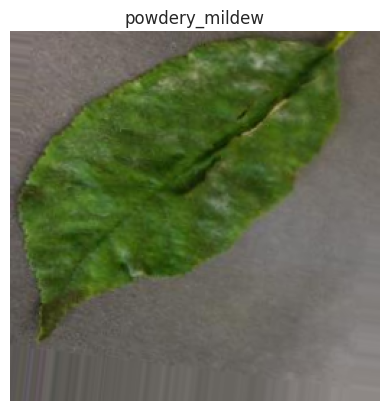

(32, 256, 256, 3)


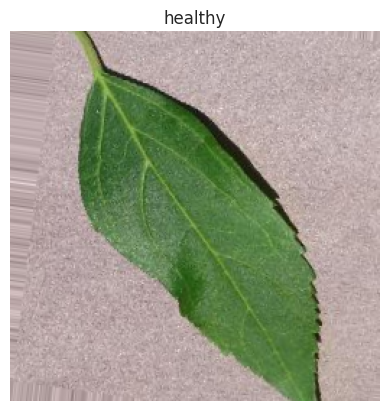

(32, 256, 256, 3)


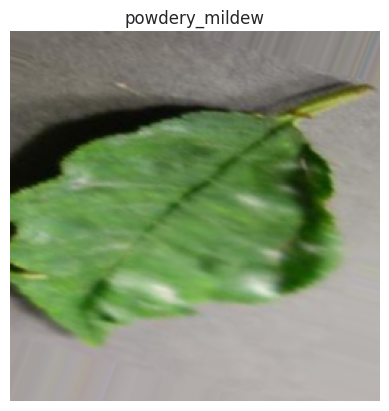

In [53]:
plot_augmented_image(train_set)

Plot Validation Image Set

(32, 256, 256, 3)


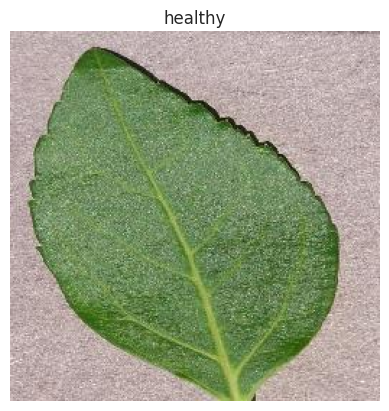

(32, 256, 256, 3)


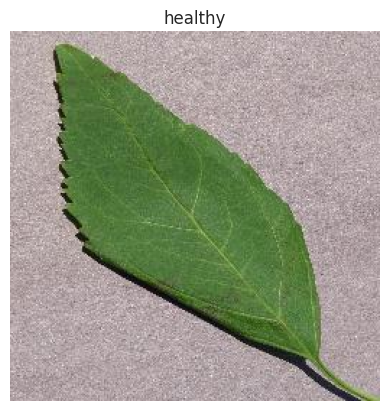

(32, 256, 256, 3)


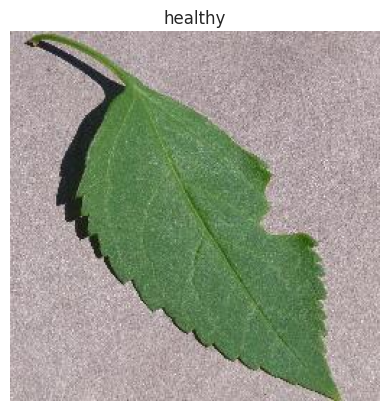

In [54]:
plot_augmented_image(validation_set)

Plot Test Image Set

(32, 256, 256, 3)


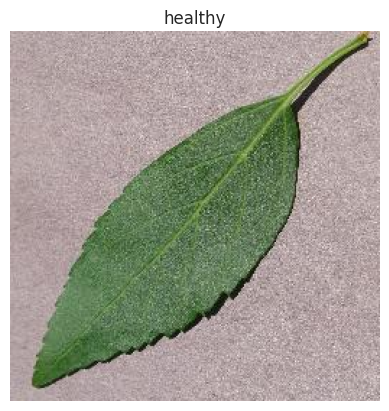

(32, 256, 256, 3)


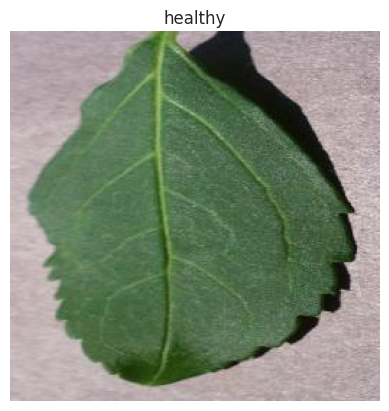

(32, 256, 256, 3)


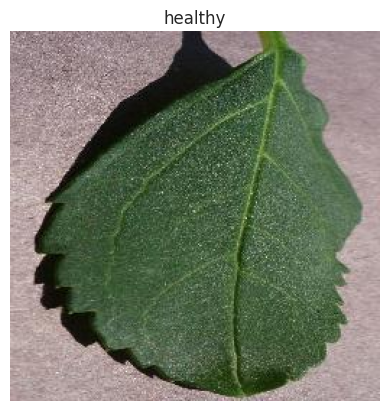

In [55]:
plot_augmented_image(test_set)

Save Class Indices

In [56]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

----

# Creating the Model

In order to meet the business requirements for the customer, a Conventional Neural Network (CNN) model as selected, that will learn from the dominant features contained within the powdery mildew images of the Cherry Leaves.

Import ML Packages

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Perameter Definintions

In [58]:
EPOCHS = 15
OUTPUT_DIR = 'outputs/v1'

ML Model

In [59]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=4, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

Model Summary

In [60]:
create_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 4)         292       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 4)         0

Early Stopping

In [61]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

Fit Model for Training

In [62]:
model = create_model()
model.fit(train_set,
          epochs=EPOCHS,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data = validation_set,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/15
92/92 [==============================] - 54s 567ms/step - loss: 0.3134 - accuracy: 0.8536 - val_loss: 0.1695 - val_accuracy: 0.9262
Epoch 2/15
92/92 [==============================] - 49s 535ms/step - loss: 0.0773 - accuracy: 0.9725 - val_loss: 0.0293 - val_accuracy: 0.9905
Epoch 3/15
92/92 [==============================] - 54s 585ms/step - loss: 0.0625 - accuracy: 0.9755 - val_loss: 0.0204 - val_accuracy: 0.9929
Epoch 4/15
92/92 [==============================] - 47s 513ms/step - loss: 0.0261 - accuracy: 0.9922 - val_loss: 0.0315 - val_accuracy: 0.9929
Epoch 5/15
92/92 [==============================] - 48s 518ms/step - loss: 0.0420 - accuracy: 0.9854 - val_loss: 0.0111 - val_accuracy: 0.9976
Epoch 6/15
92/92 [==============================] - 48s 517ms/step - loss: 0.0463 - accuracy: 0.9830 - val_loss: 0.0385 - val_accuracy: 0.9881
Epoch 7/15
92/92 [==============================] - 47s 514ms/step - loss: 0.0191 - accuracy: 0.9939 - val_loss: 0.0083 - val_accuracy: 0.9976

Save Model

In [63]:
model.save(f'{OUTPUT_DIR}/mildew_detector_model.h5')

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


-----

# Model Performance

----

Model Learning Curve

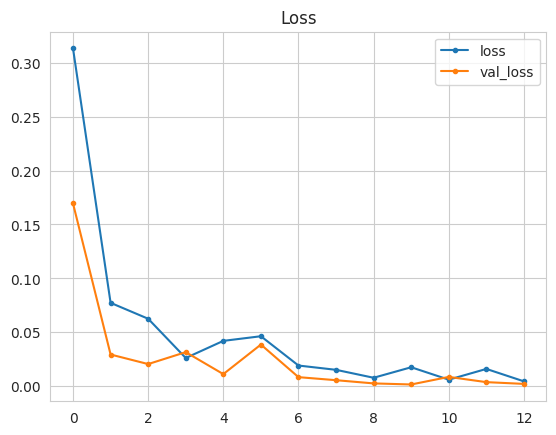

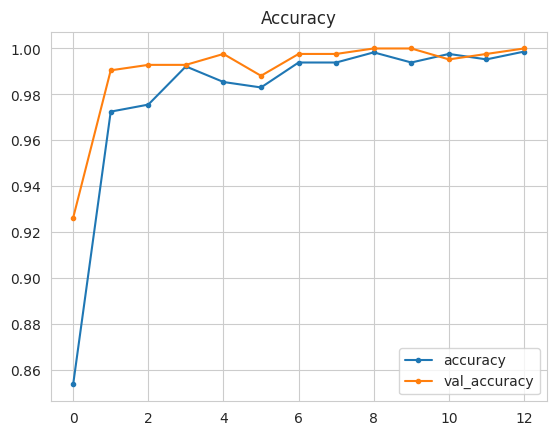

In [64]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

Model Evaluation

Load saved model

In [65]:
from keras.models import load_model
model = load_model(f'{OUTPUT_DIR}/mildew_detector_model.h5')

Evaluating the model on the test set

In [66]:
evaluation = model.evaluate(test_set)

27/27 [==============================] - 4s 155ms/step - loss: 0.0116 - accuracy: 0.9964


Save the Evaluation Pickle

In [67]:
joblib.dump(value=evaluation, filename=f'{OUTPUT_DIR}/evaluation.pkl')

['outputs/v1/evaluation.pkl']

Predict on New Data

Image shape: (256, 256), Image mode: RGB


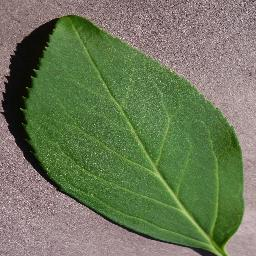

In [68]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # select Uninfected or Parasitized

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert Images to Array for Prediction Purpose

In [69]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Class Probabilities Prediction

In [70]:
prediction_probability = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
predicted_class =  target_map[prediction_probability > 0.5]  

if predicted_class == target_map[0]: prediction_probability = 1 - prediction_probability

print(f'Prediction probability: {prediction_probability}')
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 0s 84ms/step
Prediction probability: 0.9999985381790566
Predicted class: healthy


----

# Push to Github

----

* git add .

* git commit -m "->message describing alterations to cells/code and purpose"

* git push